This notebook performs various tasks. </br>
It selects a model to tag questions in the corpus. It also selects a model that assign a Data Science score to messages in the corpus. 
In both cases the best model is a simple logistic regression model trained on Tf-Idf features.
The models are selected to maximize AUC scores, and after model selection the threshold (in the cae of Question tagger) is chosen to maximize F1-score.

The question are roughly 7% of the whole dataset. While the results are not reported here, methods to take care of class imbalance have been tried (like SMOTE) but didn't provide any significant improvement.

Threads are associated to tagged questions by includid all messages in a given time interval. This time interval corresponds to 50th percentile of the thread length distribution over the training set. </br>

The training set to perform these classification tasks was obtained by handlabelling 6% (roughly 6000 messages) in the original corpus

# Content

- Function definitions
- Read data
- Q&A tagging
- Test for Q&A tagging
- Data Science message classifier
- Test for DS classifier
- Thread length analysis

# Warning!
<b> Not all the files necessary to run this notebook are included in this repository!</b>

In [ ]:
#%matplotlib inline

import pylab

import xml.etree.ElementTree as ET
import json
import pandas as pd
import re
import numpy as np
import itertools

# visualization
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
import seaborn as sns



#  machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import Lasso
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import datasets, linear_model
from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score, f1_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline

#os stuff
import os
from os import listdir
from os.path import isfile, join

from scipy import interp


#NLP
import string
import gensim
from string import punctuation
from nltk.corpus import stopwords
from nltk import word_tokenize
from gensim import corpora, models, similarities 
from gensim.models import CoherenceModel
import pyLDAvis.gensim
from gensim.parsing.preprocessing import preprocess_string,strip_tags,strip_punctuation, remove_stopwords,strip_numeric
import nltk
pyLDAvis.enable_notebook()


plt.style.use('seaborn-white')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['legend.fontsize'] = 'medium'
matplotlib.rcParams['figure.titlesize'] = 'small'


pd.set_option('display.max_colwidth', -1)

pylab.ion()

# Functions

In [298]:
def re_link(s):
    return re.sub(r'<http\S+>', ' <link> ', s)

def re_emoji(s):
    return re.sub(r':\S+:', ' <emoji> ', s)

def re_user(s):
    return re.sub(r'<@\S+>', ' <user> ', s)

# stop words
from nltk.corpus import stopwords
stopwords = stopwords.words('english') + ["'"+ x for x in stopwords.words('english')] + ["n't"]


def tokenize(text):
    words = word_tokenize(text)
    return [w.lower() for w in words]

#punctuation, removed question mark
noQ_punctuation = '!"#$%&\'()*+,-./:;<=>@[\\]^_`{|}~'

def parser(text_in): 
    
    text = unicode( re_link(re_emoji(re_user(text_in))) , "utf-8")
    
    # tokenize
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]

    # filter punctuation
    tokens = [x for x in tokens if not x in noQ_punctuation]
    tokens = [x for x in tokens if not x in ["''","``"]]

    return ' '.join(tokens)



def parser(text): #,stem): 
    flag = 0
    tokens = tokenize(unicode(text,'utf-8'))
    CUSTOM_FILTERS = [ lambda x: x.lower(), strip_tags]
    tokens = preprocess_string(' '.join(tokens), CUSTOM_FILTERS)
    if '?' in tokens:
        flag = 1
    CUSTOM_FILTERS = [ lambda x: x.lower(), strip_tags, strip_punctuation]
    tokens = preprocess_string(' '.join(tokens), CUSTOM_FILTERS)
    if flag==1:
        tokens.append('?')
    tokens = re.sub(r'\b\d+(?:\.\d+)?\s+', '', ' '.join(tokens)).split()
   
    return ' '.join(tokens)

In [367]:
#return list of accuracies, recalls, precisions and f1-scores given a list of thresholds, probability lists and true labels (labels have to be 0 ad 1)
def scores(prob_list, thresholds, true_labels): 
    accu_list=[]
    reca_list=[]
    prec_list=[]
    f1_list=[]
    p1 = prob_list[:,1]
    for thr in thresholds:
        preds = [1 if _>=thr else 0 for _ in p1]
        accu_list.append(accuracy_score(true_labels, preds))
        reca_list.append(recall_score(true_labels, preds))
        prec_list.append(precision_score(true_labels, preds))
        f1_list.append(f1_score(true_labels, preds))
    return accu_list, reca_list, prec_list, f1_list

#return cross validation averages of accuracies, recalls, precisions, f1-scores (as function of threshold), roc curve and 
#auc scores given features (X), labels (y), model, number of cv folds and binning for the threshold and false pos rate. Also return standard deviation 
#for each score on cross validation ensemble
def cv_scores_QA(X, y, tfidfmodel, model, folds, bins):
    cv = StratifiedKFold(n_splits=folds)
    tprs = []
    aucs = []
    accus = []
    recas = []
    precs = []
    f1s = []
    X = np.array([text for text in X.apply(parser).values])
    for train, test in cv.split(X, y):
        pipe=make_pipeline(tfidfmodel, model)
        probas_ = pipe.fit(X[train], y.values[train]).predict_proba(X[test])
        fpr, tpr, thres = roc_curve(y.values[test], probas_[:, 1])
        thres = list(reversed(thres))
        accu, reca, prec, f1 = scores(probas_, thres,  y.values[test])
        #true pos rate vs false pos rate (ROC)
        tprs.append(interp(bins, fpr, tpr))
        tprs[-1][0] = 0.0
        #AUC
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        #accuracy
        accus.append(interp(bins, thres, accu))
        accus[-1][0] = 0.0
        #recall
        recas.append(interp(bins, thres, reca))
        recas[-1][0] = 1.0
        #precision
        precs.append(interp(bins, thres, prec))
        precs[-1][0] = 0.0
        #F1
        f1s.append(interp(bins, thres, f1))
        f1s[-1][0] = 0.0
    #Now calculate averages and std over cv folds
    #ROC
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)
    #AUC
    mean_auc = auc(bins, mean_tpr)
    std_auc = np.std(aucs)
    #accuracy
    mean_accu = np.mean(accus, axis=0)
    mean_accu[-1] = 0.0
    std_accu = np.std(accus, axis=0)
    #recall
    mean_reca = np.mean(recas, axis=0)
    mean_reca[-1] = 0.0
    std_reca = np.std(recas, axis=0)
    #precision
    mean_prec = np.mean(precs, axis=0)
    mean_prec[-1] = 1.0
    std_prec = np.std(precs, axis=0)
    #F1
    mean_f1 = np.mean(f1s, axis=0)
    mean_f1[-1] = 0.0
    std_f1 = np.std(f1s, axis=0)
    return mean_tpr, std_tpr, mean_auc, std_auc, mean_accu, std_accu, mean_reca, std_reca, mean_prec, std_prec, mean_f1, std_f1

# Read data

In [2]:
df_labeled = pd.read_csv('noted_insightslack.csv',sep='\t')
df_labeled.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
df_labeled.shape

(5898, 6)

In [4]:
import pickle
with open("listQA.pickle", "rb") as fp:   # Unpickling
    listaQA = pickle.load(fp)
with open("listQ.pickle", "rb") as fp:   # Unpickling
    listaQ = pickle.load(fp)
with open("listDS.pickle", "rb") as fp:   # Unpickling
    listaDS = pickle.load(fp)

In [5]:
print 'number Q&A threads: ', len(listaQA)
print 'number unanswered Q: ', len(listaQ)
print 'number generic DS threads: ', len(listaDS)

number Q&A threads:  314
number unanswered Q:  98
number generic DS threads:  433


In [6]:
Q_starts = [_[0] for _ in listaQA]+[_[0] for _ in listaQ]
Qs = listaQA + listaQ

In [7]:
len(Q_starts)

412

In [8]:
df_labeled.head()

,ID,ts,user,text,tag,channel
0,45094,1.420829e+09,U03AY7TUK,<@U03AY7TUK> has joined the channel,bs,general
1,45095,1.420829e+09,U03AZQ4LE,<@U03AZQ4LE> has joined the channel,bs,general
2,45096,1.420829e+09,U03AY3FTZ,Welcome fellow Fellows!,bs,general
3,45097,1.420830e+09,U03AZQBLN,<@U03AZQBLN> has joined the channel,bs,general
4,45098,1.420830e+09,U03AY3FTZ,"Can you invite others? I've invited everyone from our class, but it'd be great to have all Fellows on this same slack, don't you think?",bs,general


In [9]:
df_labeled[(df_labeled.ID.isin(Q_starts))&(df_labeled['channel']=='general')].shape

(300, 6)

# Q&A tagging

<p>Add labels 'Q'/'NQ' to train dataframe, split train and test</p>
<p>1) Take train to be 'general' and test the rest</p>
2) Merge, shuffle and take 20% for test

In [368]:
df_labeled['Q_NQ_label'] = df_labeled['ID'].apply(lambda x: 1 if x in Q_starts else 0)

In [369]:
X_cv = df_labeled[df_labeled['channel']=='general']['text']
y_cv = df_labeled[df_labeled['channel']=='general']['Q_NQ_label']
X_test = df_labeled[df_labeled['channel']=='ds_sv_2016a']['text']
y_test = df_labeled[df_labeled['channel']=='ds_sv_2016a']['Q_NQ_label']

In [370]:
df_labeled[df_labeled['channel']=='general'].shape

(5057, 8)

In [372]:
print 'cv length:', len(X_cv)
print 'test length:', len(X_test)
print 'ratio: ', 1.0*len(X_test)/(len(X_cv)+len(X_test))

cv length: 5057
test length: 841
ratio:  0.142590708715


Simplest way to tag questions: look for '?'

/anaconda/envs/dataweekends/lib/python2.7/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/anaconda/envs/dataweekends/lib/python2.7/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


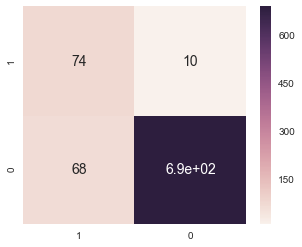

In [373]:
def has_QM(text):
    if '?' in tokenize(text):
        return 1
    else:
        return 0

test_pred = [has_QM(_) for _ in X_test.apply(parser).values]

cats = [1,0]
cm_QM = confusion_matrix(y_test.values,  test_pred, labels = cats)
df_QM = pd.DataFrame(cm_QM, index = [_ for _ in cats],
                  columns = [_ for _ in cats])
plt.figure(figsize = (5,4))
heat_plot=sns.heatmap(df_QM, annot=True)
#plt.savefig("./figs/confusion_QA_QM.pdf", bbox_inches='tight')
plt.show()

In [374]:
tp_QM = len([i for i in range(len(test_pred)) if (test_pred[i]==1)&(y_test.values[i]==1)])
tn_QM = len([i for i in range(len(test_pred)) if (test_pred[i]==0)&(y_test.values[i]==0)])
fp_QM = len([i for i in range(len(test_pred)) if (test_pred[i]==1)&(y_test.values[i]==0)])
fn_QM = len([i for i in range(len(test_pred)) if (test_pred[i]==0)&(y_test.values[i]==1)])
print 'True pos: ', tp_QM
print 'True neg: ', tn_QM
print 'False pos: ', fp_QM
print 'False neg: ', fn_QM

True pos:  74
True neg:  689
False pos:  68
False neg:  10


In [375]:
fpr_QM = fp_QM*1.0/(fp_QM+tn_QM)
tpr_QM = tp_QM*1.0/(tp_QM+fn_QM)
print 'False pos rate: ', fpr_QM
print 'True pos rate: ', tpr_QM

False pos rate:  0.0898282694848
True pos rate:  0.880952380952


# Using Tf-Idf features to train a classifier

In [376]:
# Build vocabulary
tokenized_texts = X_cv.apply(parser).apply(tokenize).values
allwords = np.concatenate(tokenized_texts)
vocabulary = set(allwords)
print "Size of vocabulary for titles:", len(vocabulary), 'words.'

Size of vocabulary for titles: 7538 words.


In [377]:
from collections import Counter
word_count = Counter(allwords)
word_count_dict = dict(word_count)
#rare words (those that appear less than 4 times)
rarewords = [ k for k, v in word_count_dict.items() if v < 4 ]
vocabulary_norare = set([_ for _ in vocabulary if _ not in rarewords])
len(vocabulary_norare)

2108

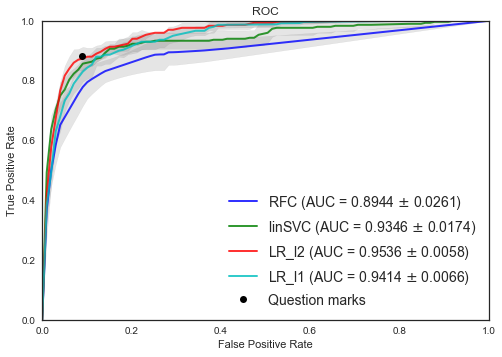

In [378]:
binning = np.linspace(0, 1, 100)
clf_labels = ['RFC', 'linSVC',  'LR_l2','LR_l1']
clf_colors =  ['b','g','r', 'c']
models = [RandomForestClassifier(), svm.SVC(kernel='linear', probability=True), LogisticRegression(penalty = 'l2'),LogisticRegression(penalty = 'l1')]
for i in range(len(models)):
    roc, droc, auc_score, dauc_score, acc, dacc, rec, drec, pre, dpre, f1, df1= cv_scores_QA(X_cv, y_cv, \
                                                            TfidfVectorizer(tokenizer=tokenize, vocabulary=vocabulary_norare),models[i], 4, binning)
    plt.plot(binning, roc, color=clf_colors[i],
         label=r'%s (AUC = %0.4f $\pm$ %0.4f)' % (clf_labels[i],auc_score, dauc_score),
         lw=2, alpha=.8)
    plt.fill_between(binning,  np.maximum(roc - droc, 0),  np.minimum(roc + droc, 1), color='grey', alpha=.2)
#plt.xlim([-0.05, 1.05])
#plt.ylim([-0.05, 1.05])
plt.plot([fpr_QM], [tpr_QM], 'ko', label='Question marks')
plt.xlim([-0.0, 1.0])
plt.ylim([-0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

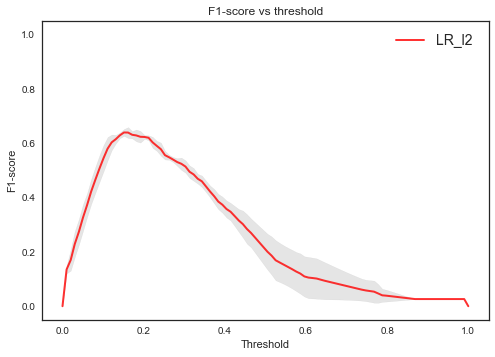

In [380]:
roc, droc, auc_score, dauc_score, acc, dacc, rec, drec, pre, dpre, f1, df1= cv_scores_QA(X_cv, y_cv, \
                                         TfidfVectorizer(tokenizer=tokenize, vocabulary=vocabulary_norare), LogisticRegression(penalty = 'l2', C=1.), 4, binning)
plt.plot(binning, f1, color='r',
         label=r'LR_l2 ' ,
         lw=2, alpha=.8)
plt.fill_between(binning,  np.maximum(f1 - df1, 0),  np.minimum(f1 + df1, 1), color='grey', alpha=.2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.title('F1-score vs threshold')
plt.legend(loc="upper right")
plt.show()

In [381]:
from operator import itemgetter
#Get the threshold with the maximal F1 in the cv set
final_threshold = max(zip(binning,f1),key=itemgetter(1))[0]
print 'Final threshold: ', final_threshold
print 'Max: ', max(f1)

Final threshold:  0.15151515151515152
Max:  0.6392410344226749


# Test

In [340]:
final_threshold = 0.2
final_model = LogisticRegression(penalty = 'l2',C=1.)
corpus_cv = np.array([text for text in X_cv.apply(parser).values])
corpus_test = np.array([text for text in X_test.apply(parser).values])
tfidf_model = TfidfVectorizer(tokenizer=tokenize, vocabulary=vocabulary_norare)
tfidf_model.fit(corpus_cv)
tfidf_X_cv = tfidf_model.transform(corpus_cv)
tfidf_X_test = tfidf_model.transform(corpus_test)
final_model.fit(tfidf_X_cv,y_cv.values)
#
prob_train = final_model.predict_proba(tfidf_X_cv)
final_preds_train =  [1 if _>=final_threshold else 0 for _ in prob_train[:,1]]
#
prob_test = final_model.predict_proba(tfidf_X_test)
final_preds_test =  [1 if _>=final_threshold else 0 for _ in prob_test[:,1]]

In [341]:
print 'Accuracy train/test: %s / %s'  %(accuracy_score(y_cv.values, final_preds_train),accuracy_score(y_test.values, final_preds_test))
print 'Precision train/test: %s / %s'  %(precision_score(y_cv.values, final_preds_train),precision_score(y_test.values, final_preds_test))
print 'Recall train/test: %s / %s'  %(recall_score(y_cv.values, final_preds_train),recall_score(y_test.values, final_preds_test))
print 'F1 train/test: %s / %s'  %(f1_score(y_cv.values, final_preds_train),f1_score(y_test.values, final_preds_test))

Accuracy train/test: 0.9723156021356536 / 0.9488703923900119
Precision train/test: 0.7339181286549707 / 0.7530864197530864
Recall train/test: 0.8366666666666667 / 0.7261904761904762
F1 train/test: 0.7819314641744548 / 0.7393939393939394


/anaconda/envs/dataweekends/lib/python2.7/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/anaconda/envs/dataweekends/lib/python2.7/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


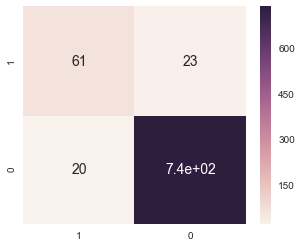

In [342]:
#Confusion matrix. Rows are true labels, column predicted
cats = [1,0]
cm_QM = confusion_matrix(y_test.values,  final_preds_test, labels = cats)
df_QM = pd.DataFrame(cm_QM, index = [_ for _ in cats],
                  columns = [_ for _ in cats])
plt.figure(figsize = (5,4))
heat_plot=sns.heatmap(df_QM, annot=True)
plt.show()

## Use selected model to tag questions

In [343]:
df=pd.read_csv('insightslack.csv',sep='\t')
data = df.copy()
df_cols_keep = ['parent_user_id','reactions', 'replies', 'reply_count', 'text',
       'thread_ts','ts','user','folder']
data = data[df_cols_keep]
del df

In [344]:
data['ID'] = data.index

In [345]:
data['is_train'] = data.ID.apply(lambda x: 1 if x in df_labeled.ID.values else 0)

In [346]:
data.text.fillna('xxx', inplace=True)

In [348]:
#all_texts = data['text']
corpus_all_texts = np.array([text for text in data['text'].apply(parser).values])
all_tfidf = tfidf_model.transform(corpus_all_texts)
all_scores = final_model.predict_proba(all_tfidf)
all_labels = ['Q' if _>=final_threshold else 'NQ' for _ in all_scores[:,1]]

In [526]:
#joblib.dump(model_LR_def, './~deliverable/logreg_QA.pkl')

['./~deliverable/logreg_QA.pkl']

In [442]:
data['Q_NQ_label'] = all_labels
# Substitute true values for training set items
dx = pd.Series(data = df_labeled.Q_NQ_label.values, index=df_labeled.ID)
dx.rename_axis(None)
dx = dict(bx)
data['n'] = data['ID'].map(bx)
data.n.fillna(data.Q_NQ_label, inplace=True)
del data['Q_NQ_label']
data.rename(columns={'n': 'Q_NQ_label'}, inplace=True)

In [521]:
data.shape

(90993, 13)

# DS/BS classifier

In [349]:
DS_treads = listaQA+listaQ+listaDS
DS = [_ for thread in DS_treads for _ in thread]
len(DS)

3279

In [357]:
df_labeled['DS_BS_label'] = df_labeled['ID'].apply(lambda x: 1 if x in DS else 0)

In [359]:
df_labeled[df_labeled['DS_BS_label']==0].shape

(2766, 8)

In [360]:
df_labeled.head()

,ID,ts,user,text,tag,channel,Q_NQ_label,DS_BS_label
0,45094,1.420829e+09,U03AY7TUK,<@U03AY7TUK> has joined the channel,bs,general,0,0
1,45095,1.420829e+09,U03AZQ4LE,<@U03AZQ4LE> has joined the channel,bs,general,0,0
2,45096,1.420829e+09,U03AY3FTZ,Welcome fellow Fellows!,bs,general,0,0
3,45097,1.420830e+09,U03AZQBLN,<@U03AZQBLN> has joined the channel,bs,general,0,0
4,45098,1.420830e+09,U03AY3FTZ,"Can you invite others? I've invited everyone from our class, but it'd be great to have all Fellows on this same slack, don't you think?",bs,general,0,0


In [361]:
cv_ds, test_ds = train_test_split(df_labeled, test_size=0.2, random_state=42342)
X_cv_ds = cv_ds['text']
y_cv_ds = cv_ds['DS_BS_label']
X_test_ds= test_ds['text']
y_test_ds = test_ds['DS_BS_label']

In [362]:
def parser_ds(text_in): 
    
    text = unicode( re_link(re_emoji(re_user(text_in))) , "utf-8")
    # tokenize
    
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    
    # filter stopwords and punctuation
    tokens = [x for x in tokens if not x in stopwords]
    tokens = [x for x in tokens if not x in string.punctuation]
    tokens = [x for x in tokens if not x in ["''","``"]]
        
    # stemming
    #tokens = [stemmer.stem(x) for x in tokens]
    #tokens = [nl_stemmer.stem(x) for x in tokens]
    return ' '.join(tokens)

In [363]:
# Build vocabulary
tokenized_texts_ds = X_cv_ds.apply(parser_ds).apply(tokenize).values
allwords_ds = np.concatenate(tokenized_texts_ds)
vocabulary_ds = set(allwords_ds)
print "Size of vocabulary for titles:", len(vocabulary_ds), 'words.'

Size of vocabulary for titles: 7939 words.


In [364]:
from collections import Counter
word_count_ds = Counter(allwords_ds)
word_count_dict_ds = dict(word_count_ds)
#rare words
rarewords_ds = [ k for k, v in word_count_dict.items() if v < 3 ]

In [365]:
vocabulary_norare_ds = set([_ for _ in vocabulary_ds if _ not in rarewords_ds])
len(vocabulary_norare_ds)

4147

In [366]:
tfidf_model_ds = TfidfVectorizer(tokenizer=tokenize, vocabulary=vocabulary_norare_ds)

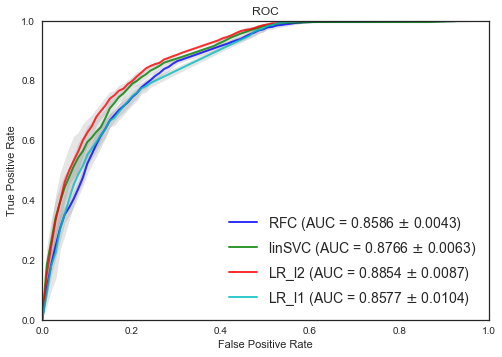

In [384]:
binning = np.linspace(0, 1, 100)
clf_labels = ['RFC', 'linSVC',  'LR_l2','LR_l1']
clf_colors =  ['b','g','r', 'c']
models = [RandomForestClassifier(), svm.SVC(kernel='linear', probability=True), LogisticRegression(penalty = 'l2'),LogisticRegression(penalty = 'l1')]
for i in range(len(models)):
    roc, droc, auc_score, dauc_score, acc, dacc, rec, drec, pre, dpre, f1, df1= cv_scores_QA(X_cv_ds, y_cv_ds, \
                                                           TfidfVectorizer(tokenizer=tokenize, vocabulary=vocabulary_norare_ds),models[i], 4, binning)
    plt.plot(binning, roc, color=clf_colors[i],
         label=r'%s (AUC = %0.4f $\pm$ %0.4f)' % (clf_labels[i],auc_score, dauc_score),
         lw=2, alpha=.8)
    plt.fill_between(binning,  np.maximum(roc - droc, 0),  np.minimum(roc + droc, 1), color='grey', alpha=.2)
plt.xlim([-0.0, 1.0])
plt.ylim([-0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

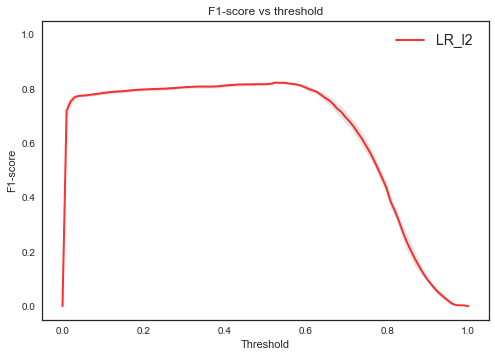

In [385]:
roc, droc, auc_score, dauc_score, acc, dacc, rec, drec, pre, dpre, f1, df1= cv_scores_QA(X_cv_ds, y_cv_ds, \
                                          TfidfVectorizer(tokenizer=tokenize, vocabulary=vocabulary_norare_ds), LogisticRegression(penalty = 'l2', C=1.), 4, binning)
plt.plot(binning, f1, color='r',
         label=r'LR_l2 ' ,
         lw=2, alpha=.8)
plt.fill_between(binning,  np.maximum(f1 - df1, 0),  np.minimum(f1 + df1, 1), color='grey', alpha=.2)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Threshold')
plt.ylabel('F1-score')
plt.title('F1-score vs threshold')
plt.legend(loc="upper right")
plt.show()

In [386]:
from operator import itemgetter
#Get the threshold with the maximal F1 in the cv set
final_threshold = max(zip(binning,f1),key=itemgetter(1))[0]
print 'Final threshold: ', final_threshold
print 'Max: ', max(f1)

Final threshold:  0.5252525252525253
Max:  0.8229971978037172


# Test

In [390]:
final_threshold = 0.6
final_model = LogisticRegression(penalty = 'l2',C=1.)
corpus_cv_ds = np.array([text for text in X_cv_ds.apply(parser).values])
corpus_test_ds = np.array([text for text in X_test_ds.apply(parser).values])
tfidf_model_ds = TfidfVectorizer(tokenizer=tokenize, vocabulary=vocabulary_norare_ds)
tfidf_model_ds.fit(corpus_cv_ds)
tfidf_X_cv_ds = tfidf_model_ds.transform(corpus_cv_ds)
tfidf_X_test_ds = tfidf_model_ds.transform(corpus_test_ds)
final_model.fit(tfidf_X_cv_ds,y_cv_ds.values)
#
prob_train = final_model.predict_proba(tfidf_X_cv_ds)
final_preds_train =  [1 if _>=final_threshold else 0 for _ in prob_train[:,1]]
#
prob_test = final_model.predict_proba(tfidf_X_test_ds)
final_preds_test =  [1 if _>=final_threshold else 0 for _ in prob_test[:,1]]

In [391]:
print 'Accuracy train/test: %s / %s'  %(accuracy_score(y_cv_ds.values, final_preds_train),accuracy_score(y_test_ds.values, final_preds_test))
print 'Precision train/test: %s / %s'  %(precision_score(y_cv_ds.values, final_preds_train),precision_score(y_test_ds.values, final_preds_test))
print 'Recall train/test: %s / %s'  %(recall_score(y_cv_ds.values, final_preds_train),recall_score(y_test_ds.values, final_preds_test))
print 'F1 train/test: %s / %s'  %(f1_score(y_cv_ds.values, final_preds_train),f1_score(y_test_ds.values, final_preds_test))

Accuracy train/test: 0.8838490885968631 / 0.7940677966101695
Precision train/test: 0.9082914572864321 / 0.815831987075929
Recall train/test: 0.8682946357085669 / 0.7965299684542587
F1 train/test: 0.8878428162095784 / 0.8060654429369514


/anaconda/envs/dataweekends/lib/python2.7/site-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/anaconda/envs/dataweekends/lib/python2.7/site-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


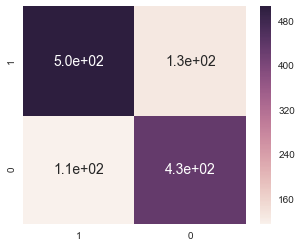

In [392]:
#Confusion matrix. Rows are true labels, column predicted
cats = [1,0]
cm_DS = confusion_matrix(y_test_ds.values,  final_preds_test, labels = cats)
df_DS = pd.DataFrame(cm_DS, index = [_ for _ in cats],
                  columns = [_ for _ in cats])
plt.figure(figsize = (5,4))
heat_plot=sns.heatmap(df_DS, annot=True)
plt.show()

## Predict DS score on dataset

In [394]:
corpus_all_texts_ds = np.array([text for text in data['text'].apply(parser).values])
all_tfidf_ds = tfidf_model_ds.transform(corpus_all_texts_ds)
all_scores_ds = final_model.predict_proba(all_tfidf_ds)

In [477]:
data['DS_score'] = all_scores_ds[:,1]

In [478]:
folderstokeep = [ 'bos-2018a', 'nlp', 'ds-idx-2018a', 'portland-alumni',  'controls_engineering', 'leads', 'devops', 'networkx', 'ds-ny-2017a',  'sv', 'pegasus-users', 'analytics-infra', 'linkedin-demo-group', 'sparknotes', 'ds-sv-2012b', 'bos-2017b', 'bos-2017c', 'cinch_demo', 'modena_demo', 'hd-bos-2016a', 'hd-bos-2016c', 'hd-bos-2016b', 'askflask', 'ghc17', 'bos-2017c-questions', '2016', 'hardest-ds-questions', 'hd-sv-17a-git',  'bos17c_project-ideas', 'python', 'de-ny-2016a', 'de-ny-2016b', 'de-ny-2016c', 'scala', 'harvardthcsph', 'redshift', 'user-engagement', 'dataframe-sql-dbas', 'seattle-alumni', 'de-ny-2015c', 'kdd2016', 'project_discussion', 'fb_analytics_2016a_sv',  'extronomers-ny', 'hd-bos-2017a',  'sv-2015a',  'webscraping', 'ds-idx-2016b', 'ds-idx-2016a', 'london-alumni', 'athenahealth-demo', 'interviews', 'insight_compass_demo', 'sf-alumni', 'rev-2018', 'customer-segmentation', 'dataengineering', 'ds-idx-2017a', 'ds-ny-2015c', 'docker_kubernetes',  'at_t_2016-ds-sv',  'ds-sv-2014a', 'ds-sv-2014b', 'ds-sv-2014c', 'workshops', 'de-sv-2016a', 'de-sv-2016b', 'de-sv-2016c', 'kfc_pod', '17a-cs-sp', 'gdpr', 'bos-tech-advisors', 'swim-sv', 'teamtiki', 'time-series-models', 'bhe-demo', 'ds-idx-2017b', 'ds-idx-2017c', 'msk-visit',  'ds-sv-2015b-trips', 'ds-sea-2018a', 'kpmg-demo-2015c', '2015c-teralytics-demo', 'san_diego',  'wayfair_on-site', 'ds-sv-2015c', 'ds-sv-2015b', 'ds-sv-2015a', 'slack_feature_test', 'insightnycfall2017', 'de-sv-2017a', 'ml-meetup-ca', 'elasticsearch', 'scalala', 'hubspot_demo',  '2015c-recombine-visit', 'insight_om1_demo',  'ds-sv-2012a', 'bos17b_callmemaybe', 'de-sv-2014b', 'de-sv-2014c', 'sql',  'product-management', 'cornerstone-visit', 'ghc-18', 'badminton',  'learning', 'spark-tutorial',  'bostoninsightalumni',  'ds-sv-2016a',  '2105c-viacom-visit', 'insightatnight', 'ds-sea-2017b',  'ds-idx-2015c', 'data_challenges', 'capital-one-on-site', 'la-alumni', 'twitch_demo_2016a', '2015c-bonobos-visit', 'bos2018',  'pymc_latent_dirichel', 'user-embedding', 'nyc-alumni', 'tensorflow', 'remote', 'pinterest_march1', 'statistical-learning', 'ds-ny-2016a', 'ds-sv-2017a',  'ds-ny-2014b',  'ds-sv-2016c', 'outdoor-sv', 'ml', 'bos17-mgh-demo', 'musicmagic', 'dogs', 'odsc2017', 'paul_iqt_ama', 'r', 'de-sv-2015a', 'deep_learning', 'de-sv-2015c', 'de-sv-2015b', 'deep-learning-group', 'seven_bridges_demo', 'nyc_dinners', 'ml-meetup-ny', 'ds-idx-2015b', 'fellow-tech-questions', 'ai', 'boston', 'recommendation-engine', 'social-science', 'general', 'deep-learning', 'ds-sv-2013a', 'de_issues', 'ds-sv-2013c', 'ds-sv-2013b', 'in-q-tel',  'dnanexus-demo', 'odsc-east2018', 'bos-2017-dicussion', 'yelp_2016a_sv', 'deprecated-de-ny', 'cvs-demo', 'boston-insighters', 'ds-sv-2015c-startups', 'startup-v-established', 'strata-sanjose-2016', 'ds-ny-2015b', '2015c-gartner-visit', 'ai-sv-2017c', 'pymetrics-visit', 'ai-sv-2017a',  'ds-ny-2015a', 'interview-questions', 'wayfair_callbacks', 'oscar-visit', 'data_challenges_ny15b', 'raleigh-durham-alumni', 'data_science_tools', 'dc-alumni', 'sql-results', 'minnesota-alumni', 'ds-ny-2016b', 'visualizations', 'hd-bos-2015b',  'east_bay_housing']
data_1 = data[data['folder'].isin(folderstokeep)]
#tagged questions
data_1_Qs = data_1[data_1['Q_NQ_label']=='Q']['ID'].values

# Extract threads with replies

In [479]:
data_1_Qs_withreplies = data_1[(data_1['ID'].isin(data_1_Qs) )&(data_1['replies'].notnull())&(data_1['is_train']==0)]['ID'].values
print "Number of threads with reply: ", len(data_1_Qs_withreplies)

Number of threads with reply:  390


In [480]:
threads_with_replies = []
for _ in data_1_Qs_withreplies:
    thread = [_]
    ts_thread = get_replies_ts(data_1[data_1['ID'] ==_]['replies'].values[0])
    ids = [data_1[(np.abs(data_1['ts'] -time)<.01)]['ID'].values[0] for time in ts_thread]
    threads_with_replies.append(thread+ids)

In [481]:
import pickle
with open("list_threads_w_replies.pickle", "wb") as fp:   #Pickling
    pickle.dump(threads_with_replies, fp)

# Extract threads with no replies

### Explore thread structure

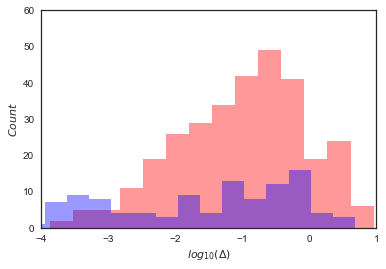

In [486]:
lengthsQA = np.array([df_labeled[df_labeled.ID==_[-1]]['ts'].values[0] - df_labeled[df_labeled.ID==_[0]]['ts'].values[0] for _ in listaQA])
lengthsDS = np.array([df_labeled[df_labeled.ID==_[-1]]['ts'].values[0] - df_labeled[df_labeled.ID==_[0]]['ts'].values[0] for _ in listaDS])

fig, ax = plt.subplots(figsize=(6, 4))
sns.distplot(pd.Series(np.log10((lengthsQA+10**-1)/3600/24.)),bins=20, kde = False,color='r')
sns.distplot(pd.Series(np.log10((lengthsDS+10**-1)/3600/24.)),bins=20, kde = False,color='b')
plt.ylabel(r'$Count$')
plt.xlabel(r'$log_{10}(\Delta)$')
plt.xlim(-4, 1)
plt.ylim(0, 60)
plt.show()

In [487]:
df_labeled['@ing']=df_labeled['text'].str.contains('<@U')
listaQA_flat = [_ for x in listaQA for _ in x]

In [488]:
df_labeled_QA_notatting = df_labeled[(df_labeled['ID'].isin(listaQA_flat))&(-df_labeled['@ing'])]
listaQA_notatting = [list(set(_).intersection(set(df_labeled_QA_notatting['ID'].values))) for _ in listaQA]
listaQA_notatting = [np.sort(_) for _ in listaQA_notatting if len(_)>1]
lengthsQA_notatting = np.array([df_labeled[df_labeled.ID==_[-1]]['ts'].values[0] - df_labeled[df_labeled.ID==_[0]]['ts'].values[0] for _ in listaQA_notatting])

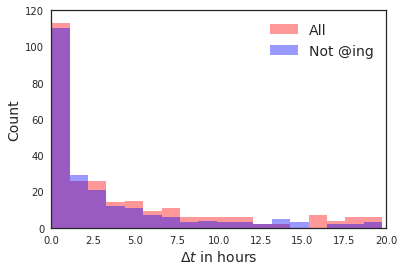

In [518]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.distplot(pd.Series(((lengthsQA)/3600.)),bins=200, kde = False,color='r', label='All')
sns.distplot(pd.Series(((lengthsQA_notatting)/3600.)),bins=200, kde = False,color='b' , label='Not @ing')
plt.ylabel(r'Count', fontsize=14)
plt.xlabel(r'$\Delta t$ in hours',fontsize=14)
plt.xlim(0, 20)
plt.ylim(0, 120)
plt.legend()
plt.savefig("./figs/threads_duration.pdf", bbox_inches='tight')
plt.show()

In [490]:
print "50 percentile w/ @, dt: ", np.percentile(lengthsQA, 50)
print "75 percentile w/ @, dt: ", np.percentile(lengthsQA, 75)
print "50 percentile w/o @, dt: ", np.percentile(lengthsQA_notatting, 50)
print "75 percentile w/o @, dt: ", np.percentile(lengthsQA_notatting, 75)

50 percentile w/ @, dt:  9697.0
75 percentile w/ @, dt:  42110.0
50 percentile w/o @, dt:  6021.0
75 percentile w/o @, dt:  24550.75


### 2 hours cutoff

In [495]:
#Also impose a good DS score
data_1_Qs_withoutreplies = data_1[(data_1['ID'].isin(data_1_Qs) )&(data_1['replies'].isnull())&(data_1['is_train']==0)&(data_1['DS_score']>0.85)]['ID'].values
print "Number of threads without reply: ", len(data_1_Qs_withoutreplies)

Number of threads without reply:  725


In [496]:
threads_without_replies = []
for _ in data_1_Qs_withoutreplies:
    thread = [_]
    time =  data_1[data_1['ID']==_]['ts'].values[0]
    channel = data_1[data_1['ID']==_]['folder'].values[0]
    ids = list(data_1[(data_1['folder']==channel)&(data_1['ts']-time>0)&(data_1['ts']-time<3600*2.0)&(data_1['DS_score']>0.1)]['ID'].values)
    threads_without_replies.append(thread+ids)

In [497]:
with open("list_threads_wo_replies.pickle", "wb") as fp:   #Pickling
    pickle.dump(threads_without_replies, fp)

# Savings

In [485]:
data.to_csv('insightslack_processed.csv', sep='\t', encoding='utf-8')